# Class TemporalGraph

In [2]:
from functools import lru_cache
import os
import json
import networkx as nx
class TemporalGraph:
    def __init__(self, files):
        """
        Initialize TemporalGraph with a list of JSON files representing graphs at different timestamps.
        """
        self.files = files  # List of JSON file paths

    @lru_cache(maxsize=10)  # Cache the last 10 accessed timestamps
    def load_graph_at_timestamp(self, timestamp):
        """
        Load the graph for a specific timestamp from JSON and convert it to a NetworkX graph.
        """
        with open(self.files[timestamp], 'r') as f:
            data = json.load(f)
        return self._json_to_graph(data)

    def _json_to_graph(self, data):
        """
        Convert JSON data to a NetworkX graph.
        """
        graph = nx.DiGraph() if data["directed"] else nx.Graph()
        
        # Add nodes
        
        for node_type, nodes in data["node_values"].items():
            for node in nodes:
                node_id = node[-1]  # Assuming the node ID is the last element in the list
                node_attributes = dict(zip(data["node_types"][node_type], node))
                graph.add_node(node_id, **node_attributes)  # Add the node with its attributes
            
                
        # Add edges
        all_edge_types = data["relationship_types"]

        for i in data["relationship_values"] :
            
            if i[0] in all_edge_types :
                
                attributes = {}
                for j in range(len(i)-2) :
                    key = all_edge_types[i[0]][j]
                    attributes[key] = i[j]

                graph.add_edge(i[-2],i[-1],**attributes)
            else :
                graph.add_edge(i[0],i[1])
    
        
        return graph



# Queries

In [3]:
import time  # Ensure this is imported properly
import tracemalloc
import functools

def time_and_memory(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        # Start tracking memory and time
        tracemalloc.start()
        start_time = time.time()  # Ensure time module is used correctly
        
        try:
            # Call the actual function
            result = func(*args, **kwargs)
        finally:
            # Calculate memory and time usage
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            end_time = time.time()
            elapsed_time = end_time - start_time

            # Print results
            print(f"Time taken by '{func.__name__}': {elapsed_time:.2f} seconds")
            print(f"Memory used by '{func.__name__}': {current / 1024:.2f} KiB (Current), {peak / 1024:.2f} KiB (Peak)")

        return result
    return wrapper

In [ ]:
import glob
import re

# Natural sorting function
def natural_sort(files):
    # Extract numeric parts from filenames for sorting
    return sorted(files, key=lambda x: int(re.search(r'timestamp_(\d+)', x).group(1)))

# Get files and sort
files = glob.glob("/home/rm_subhiksha/LAM_SRM/Query_jsongraph/Dataset_Surya/supply_chain_export_1025/supply_chain_export/timestamp_*.json")
files = natural_sort(files)

# Initialize TemporalGraph
temporal_graph = TemporalGraph(files)
temporal_graph.files

[]

### Node Attributes

In [5]:
@time_and_memory
def nodeattr_json(temporal_graph, timestamp, node_id):
    """
    Retrieve node attributes for a given node ID from the JSON data at a specific timestamp.
    """
    with open(temporal_graph.files[timestamp], 'r') as f:
        data = json.load(f)
    
    for node_type, nodes in data["node_values"].items():
        for node in nodes:
            if node[-1] == node_id:
                node_attributes = dict(zip(data["node_types"][node_type], node))
                return node_attributes
    return None  # If node ID is not found

@time_and_memory
def nodeattr_nx(temporal_graph, timestamp, node_id):
    """
    Retrieve node attributes for a given node ID from the NetworkX graph at a specific timestamp.
    """
    graph = temporal_graph.load_graph_at_timestamp(timestamp)
    if node_id in graph:
        return graph.nodes[node_id]
    return None  # If node ID is not found


In [6]:
# Query node attributes using JSON data
node_attributes_json = nodeattr_json(temporal_graph, 1, "BG_001")
print("Node Attributes from JSON:", node_attributes_json)

# Query node attributes using NetworkX graph
node_attributes_nx = nodeattr_nx(temporal_graph, 0, "BG_001")
print("Node Attributes from NetworkX:", node_attributes_nx)


Time taken by 'nodeattr_json': 0.09 seconds
Memory used by 'nodeattr_json': 5.70 KiB (Current), 6986.39 KiB (Peak)
Node Attributes from JSON: {'node_type': 'BusinessGroup', 'name': 'Etch', 'description': 'Etch Business Unit', 'revenue': 2631.3317946558336, 'id': 'BG_001'}
Time taken by 'nodeattr_nx': 0.16 seconds
Memory used by 'nodeattr_nx': 6770.97 KiB (Current), 8659.15 KiB (Peak)
Node Attributes from NetworkX: {'node_type': 'BusinessGroup', 'name': 'Etch', 'description': 'Etch Business Unit', 'revenue': 3102.9209987102945, 'id': 'BG_001'}


### Shortest Path

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

@time_and_memory
def shortest_path_query(temporal_graph, timestamp, source, target, weight=None):
    """
    Finds the shortest path between two nodes in the graph at a specific timestamp and plots the path alone.

    Parameters:
        temporal_graph (TemporalGraph): The temporal graph object.
        timestamp (int): The timestamp to retrieve the graph for.
        source (str): The source node ID.
        target (str): The target node ID.
        weight (str): Optional edge attribute to use as weight for a weighted shortest path.

    Returns:
        list: The shortest path as a list of node IDs.
        float: The total cost of the path (if weighted).
    """
    try:
        # Load the graph at the given timestamp
        graph = temporal_graph.load_graph_at_timestamp(timestamp)
        
        # Find the shortest path
        if weight:
            path = nx.shortest_path(graph, source=source, target=target, weight=weight)
            cost = nx.shortest_path_length(graph, source=source, target=target, weight=weight)
        else:
            path = nx.shortest_path(graph, source=source, target=target)
            cost = len(path) - 1  # Unweighted cost is the number of edges
        
        # Plot the shortest path
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(graph)  # Positioning of the nodes
        
        # Get edges in the path
        path_edges = list(zip(path[:-1], path[1:]))  # Generate edges from the path

        # Draw the nodes and edges of the path
        nx.draw_networkx_nodes(graph, pos, nodelist=path, node_color="lightgreen", node_size=600)
        nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color="red", width=2)
        nx.draw_networkx_labels(graph, pos, labels={node: node for node in path}, font_size=12, font_weight="bold")
        
        plt.title(f"Shortest Path from {source} to {target}")
        plt.axis("off")  # Turn off the axis for better visualization
        plt.show()

        return path, cost

    except nx.NetworkXNoPath:
        print(f"No path found between {source} and {target}.")
        return None, None
    except nx.NodeNotFound as e:
        print(f"Node not found: {e}")
        return None, None

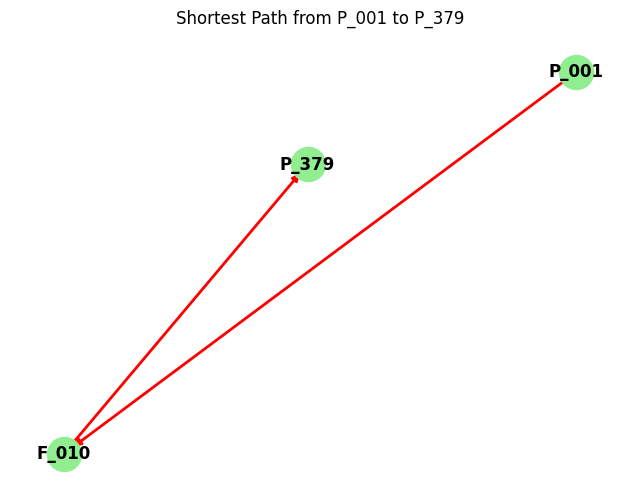

Time taken by 'shortest_path_query': 7.39 seconds
Memory used by 'shortest_path_query': 9596.84 KiB (Current), 10705.83 KiB (Peak)
Shortest path: ['P_001', 'F_010', 'P_379']
Total cost: 2


In [8]:
path, cost = shortest_path_query(temporal_graph, 0, 'P_001', 'P_379')
print(f"Shortest path: {path}")
print(f"Total cost: {cost}")

### Valid Products in a given date range

In [9]:
import json
from datetime import datetime

# Assuming the TemporalGraph class has a method `load_graph_at_timestamp` for loading graphs at specific timestamps.

@time_and_memory
def query_valid_parts_nx(temporal_graph, timestamp, start_date: str, end_date: str):
    """
    Retrieve valid parts based on their validity period from the NetworkX graph at a specific timestamp.

    Parameters:
        temporal_graph (TemporalGraph): The TemporalGraph object.
        timestamp (str): The timestamp for which to retrieve the graph.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
        list: List of node IDs representing valid parts within the specified date range.
    """
    # Convert start and end dates to datetime objects
    try:
        start_date = datetime.strptime(start_date, "%Y-%m-%d")
        end_date = datetime.strptime(end_date, "%Y-%m-%d")
    except ValueError as e:
        print(f"Error parsing dates: {e}")
        return []

    # Load the graph at the given timestamp
    graph = temporal_graph.load_graph_at_timestamp(timestamp)
    
    # List to store valid parts (node IDs)
    valid_parts = []
    
    # Iterate through the nodes in the graph
    for node, attributes in graph.nodes(data=True):
        # Extract valid_from and valid_till, with default empty string if not present
        valid_from_str = attributes.get('valid_from', '')
        valid_till_str = attributes.get('valid_till', '')
        
        # Only process valid nodes with valid dates
        if valid_from_str and valid_till_str:
            try:
                valid_from = datetime.strptime(valid_from_str, "%Y-%m-%d")
                valid_till = datetime.strptime(valid_till_str, "%Y-%m-%d")
                
                # Check if the node is valid within the given date range
                if valid_from <= end_date and valid_till >= start_date:
                    valid_parts.append(node)
            except ValueError:
                # Handle any invalid date format gracefully
                print(f"Skipping node {node} due to invalid date format.")
                continue
    
    return valid_parts


@time_and_memory
def query_valid_parts_json(temporal_graph, timestamp: int, start_date: str, end_date: str):
    """
    Retrieve valid parts based on their validity period from a JSON-like structure at a specific timestamp.

    Parameters:
        temporal_graph (TemporalGraph): The TemporalGraph object.
        timestamp (int): The timestamp (as an integer) for which to retrieve the JSON data.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
        list: List of node IDs representing valid parts within the specified date range.
    """
    # Convert start and end dates to datetime objects
    try:
        start_date = datetime.strptime(start_date, "%Y-%m-%d")
        end_date = datetime.strptime(end_date, "%Y-%m-%d")
    except ValueError as e:
        print(f"Error parsing dates: {e}")
        return []

    # Load the JSON data at the given timestamp
    with open(temporal_graph.files[timestamp], 'r') as f:
        data = json.load(f)
    
    # List to store valid parts (node IDs)
    valid_parts = []

    # Access the node values from the data
    node_values = data.get("node_values", {}).get("Parts", [])
    
    # Iterate over nodes to check validity dates
    for node in node_values:
        # Extract valid_from and valid_till
        try:
            valid_from = datetime.strptime(node[6], "%Y-%m-%d")  # Assuming 'valid_from' is at index 4
            valid_till = datetime.strptime(node[7], "%Y-%m-%d")  # Assuming 'valid_till' is at index 5
        except ValueError:
            print(f"Skipping node due to invalid date format: {node}")
            continue
        
        # Extract node ID (last element in node list)
        node_id = node[-1]

        # If the node is valid within the given range, add it to the list
        if valid_from <= end_date and valid_till >= start_date:
            valid_parts.append(node_id)

    return valid_parts

In [10]:
valid_parts_nx = query_valid_parts_nx(temporal_graph,1, start_date="2026-10-17", end_date="2026-12-17")
print(f"Valid Parts from NetworkX: {valid_parts_nx}")

Time taken by 'query_valid_parts_nx': 0.24 seconds
Memory used by 'query_valid_parts_nx': 6773.75 KiB (Current), 8661.81 KiB (Peak)
Valid Parts from NetworkX: ['P_007', 'P_010', 'P_011', 'P_017', 'P_023', 'P_033', 'P_035', 'P_036', 'P_037', 'P_059', 'P_064', 'P_069', 'P_084', 'P_094', 'P_097', 'P_100', 'P_101', 'P_105', 'P_110', 'P_112', 'P_121', 'P_125', 'P_129', 'P_134', 'P_136', 'P_142', 'P_144', 'P_153', 'P_156', 'P_162', 'P_191', 'P_205', 'P_217', 'P_223', 'P_234', 'P_236', 'P_241', 'P_247', 'P_259', 'P_266', 'P_270', 'P_273', 'P_274', 'P_284', 'P_288', 'P_290', 'P_292', 'P_298', 'P_313', 'P_314', 'P_315', 'P_319', 'P_330', 'P_331', 'P_336', 'P_339', 'P_344', 'P_346', 'P_358', 'P_372', 'P_373', 'P_380', 'P_383', 'P_392', 'P_399', 'P_401', 'P_406', 'P_413', 'P_418', 'P_419', 'P_420', 'P_432', 'P_444', 'P_454', 'P_455', 'P_457', 'P_459', 'P_460', 'P_471', 'P_478', 'P_480', 'P_485', 'P_489', 'P_497']


In [11]:
# Example for querying valid parts from JSON data
valid_parts_json = query_valid_parts_json(temporal_graph, timestamp=0, start_date="2026-10-17", end_date="2026-12-17")
print(f"Valid Parts from JSON: {valid_parts_json}")

Time taken by 'query_valid_parts_json': 0.14 seconds
Memory used by 'query_valid_parts_json': 10.75 KiB (Current), 6987.00 KiB (Peak)
Valid Parts from JSON: ['P_007', 'P_010', 'P_011', 'P_017', 'P_023', 'P_033', 'P_035', 'P_036', 'P_037', 'P_059', 'P_064', 'P_069', 'P_084', 'P_094', 'P_097', 'P_100', 'P_101', 'P_105', 'P_110', 'P_112', 'P_121', 'P_125', 'P_129', 'P_134', 'P_136', 'P_142', 'P_144', 'P_153', 'P_156', 'P_162', 'P_191', 'P_205', 'P_217', 'P_223', 'P_234', 'P_236', 'P_241', 'P_247', 'P_259', 'P_266', 'P_270', 'P_273', 'P_274', 'P_284', 'P_288', 'P_290', 'P_292', 'P_298', 'P_313', 'P_314', 'P_315', 'P_319', 'P_330', 'P_331', 'P_336', 'P_339', 'P_344', 'P_346', 'P_358', 'P_372', 'P_373', 'P_380', 'P_383', 'P_392', 'P_399', 'P_401', 'P_406', 'P_413', 'P_418', 'P_419', 'P_420', 'P_432', 'P_444', 'P_454', 'P_455', 'P_457', 'P_459', 'P_460', 'P_471', 'P_478', 'P_480', 'P_485', 'P_489', 'P_497']


### N most frequent subtype in parts

In [12]:
from collections import Counter
import json

@time_and_memory
def query_most_common_subtypes_json(temporal_graph, timestamp: int, n: int):
    """
    Retrieve the n most common subtypes from the JSON-like structure at a specific timestamp.

    Parameters:
        temporal_graph (TemporalGraph): The TemporalGraph object.
        timestamp (int): The timestamp (as an integer) for which to retrieve the JSON data.
        n (int): The number of most common subtypes to return.

    Returns:
        list: List of tuples with the subtype and its occurrence count.
    """
    # Load the JSON data at the given timestamp
    with open(temporal_graph.files[timestamp], 'r') as f:
        data = json.load(f)
    
    # List to store subtypes
    subtypes = []

    # Access the node values from the data
    node_values = data.get("node_values", {}).get("Parts", [])
    
    # Iterate over nodes and extract the subtypes (index 3 is the position of 'subtype' in the data schema)
    for node in node_values:
        subtypes.append(node[3])

    # Use Counter to count occurrences of each subtype
    subtype_counts = Counter(subtypes)

    # Get the n most common subtypes
    most_common_subtypes = subtype_counts.most_common(n)

    return most_common_subtypes

from collections import Counter

@time_and_memory
def query_most_common_subtypes_nx(temporal_graph, timestamp: int, n: int):
    """
    Retrieve the n most common subtypes from the NetworkX graph at a specific timestamp.

    Parameters:
        temporal_graph (TemporalGraph): The TemporalGraph object.
        timestamp (int): The timestamp (as an integer) for which to retrieve the graph.
        n (int): The number of most common subtypes to return.

    Returns:
        list: List of tuples with the subtype and its occurrence count.
    """
    # Load the graph at the given timestamp
    graph = temporal_graph.load_graph_at_timestamp(timestamp)

    # List to store subtypes
    subtypes = []

    # Iterate through the nodes in the graph and extract the 'subtype' from the node attributes
    for node, attributes in graph.nodes(data=True):
        subtype = attributes.get('subtype', None)
        if subtype:
            subtypes.append(subtype)

    # Use Counter to count occurrences of each subtype
    subtype_counts = Counter(subtypes)

    # Get the n most common subtypes
    most_common_subtypes = subtype_counts.most_common(n)

    return most_common_subtypes



In [13]:
# Example for querying the most common subtypes from JSON data
most_common_subtypes_json = query_most_common_subtypes_json(temporal_graph, timestamp=0, n=5)
print(f"Most Common Subtypes from JSON: {most_common_subtypes_json}")

# Example for querying the most common subtypes from NetworkX graph
most_common_subtypes_nx = query_most_common_subtypes_nx(temporal_graph, timestamp=0, n=5)
print(f"Most Common Subtypes from NetworkX: {most_common_subtypes_nx}")


Time taken by 'query_most_common_subtypes_json': 0.10 seconds
Memory used by 'query_most_common_subtypes_json': 12.91 KiB (Current), 6984.02 KiB (Peak)
Most Common Subtypes from JSON: [('electronic_component', 72), ('plastic_component', 63), ('chemical', 62), ('metal_rod', 58), ('metal_sheet', 45)]
Time taken by 'query_most_common_subtypes_nx': 0.00 seconds
Memory used by 'query_most_common_subtypes_nx': 0.18 KiB (Current), 4.80 KiB (Peak)
Most Common Subtypes from NetworkX: [('electronic_component', 72), ('plastic_component', 63), ('chemical', 62), ('metal_rod', 58), ('metal_sheet', 45)]


### Plotting average of an attribute over timestamps.

In [14]:
import matplotlib.pyplot as plt
@time_and_memory
def track_attribute_over_time(temporal_graph, node_type, attribute):
    """
    Tracks the value of a specified attribute for a given node type across all timestamps
    and plots a graph showing the trend over time.
    
    Parameters:
        temporal_graph (TemporalGraph): The temporal graph containing the data.
        node_type (str): The type of node to track (e.g., "Parts").
        attribute (str): The attribute to track (e.g., "cost").
    """
    # Store timestamp and aggregated attribute values
    timestamps = []
    attribute_values = []
    
    # Iterate over all timestamps in the temporal graph
    for timestamp in range(len(temporal_graph.files)):
        # Load the data for the current timestamp
        with open(temporal_graph.files[timestamp], 'r') as f:
            data = json.load(f)
        
        # Check if the node type exists in the data
        if node_type in data["node_values"]:
            # Extract attribute values for all nodes of the given type
            values = [
                node[data["node_types"][node_type].index(attribute)]
                for node in data["node_values"][node_type]
                if attribute in data["node_types"][node_type]
            ]
            # Aggregate the attribute values (e.g., average)
            if values:
                timestamps.append(timestamp)  # Use 0-based timestamp indexing
                attribute_values.append(sum(values) / len(values))  # Example: Average value
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, attribute_values, marker='o', linestyle='-', color='b')
    plt.title(f"Trend of '{attribute}' for Node Type '{node_type}' Over Time")
    plt.xlabel("Timestamps")
    plt.ylabel(attribute.capitalize())
    plt.xticks(timestamps)  # Use integer timestamps as x-ticks
    plt.grid()
    plt.tight_layout()
    plt.show()


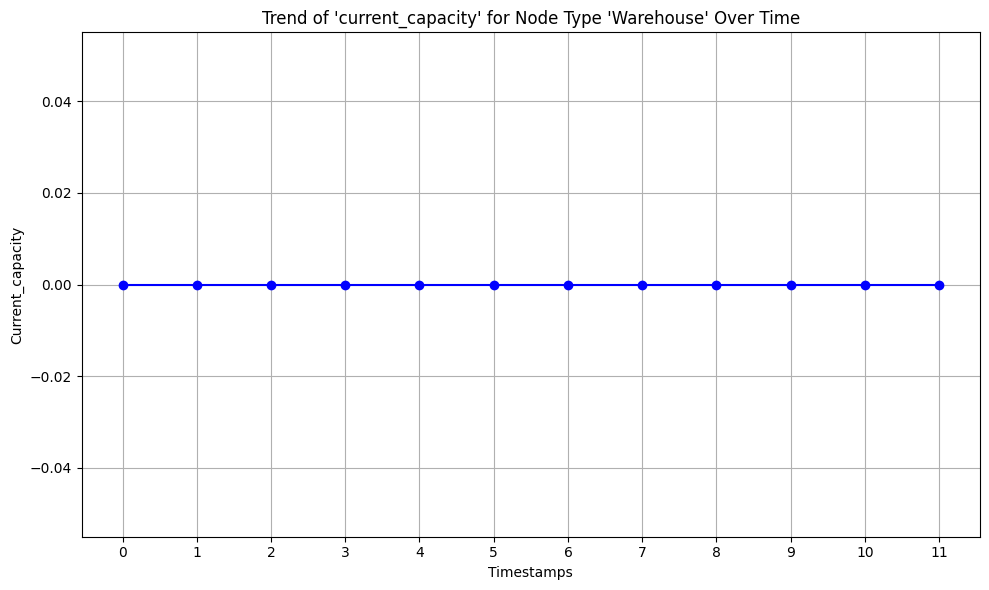

Time taken by 'track_attribute_over_time': 1.27 seconds
Memory used by 'track_attribute_over_time': 812.12 KiB (Current), 12039.89 KiB (Peak)


In [15]:
track_attribute_over_time(temporal_graph, node_type="Warehouse", attribute="current_capacity")


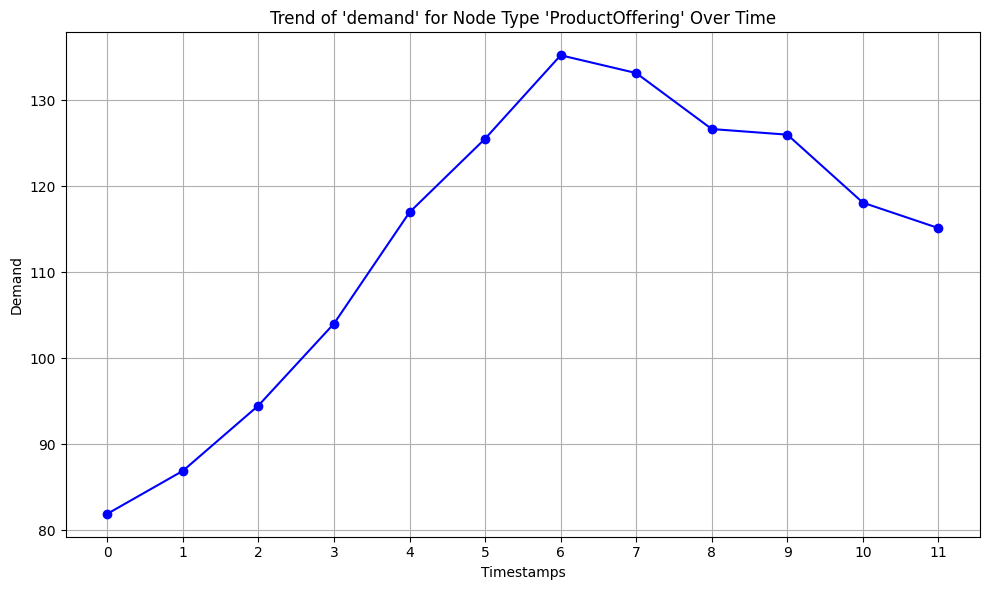

Time taken by 'track_attribute_over_time': 1.17 seconds
Memory used by 'track_attribute_over_time': 848.29 KiB (Current), 12039.29 KiB (Peak)


In [16]:
track_attribute_over_time(temporal_graph, node_type="ProductOffering", attribute="demand")

### Node id attributes accross timestamps

In [17]:
import matplotlib.pyplot as plt

@time_and_memory
def plot_attribute_for_node(temporal_graph, node_id, attribute):
    """
    Plots the value of a specified attribute for a given node ID across all timestamps.
    Raises an error if the attribute is not present in the node.

    Parameters:
        temporal_graph (TemporalGraph): The temporal graph containing the data.
        node_id (str): The ID of the node to track.
        attribute (str): The attribute to track (e.g., "cost").
    """
    # Store timestamp and attribute values
    timestamps = []
    attribute_values = []
    
    # Flag to check if the attribute is present at least once
    attribute_found = False

    # Iterate over all timestamps in the temporal graph
    for timestamp in range(len(temporal_graph.files)):
        
        # Load the data for the current timestamp
        with open(temporal_graph.files[timestamp], 'r') as f:
            data = json.load(f)
        
        
        # Check if the node ID exists in the data
        for node_type, nodes in data["node_values"].items():
    
            for subnode in nodes:

                if node_id in subnode:
                    node_index = nodes.index(subnode)
                    node_attributes = data["node_types"][node_type]
                    
                    
                    # Check if the attribute exists for this node type
                    if attribute in node_attributes:
                        attribute_found = True
                        value = data["node_values"][node_type][node_index][node_attributes.index(attribute)]
                        timestamps.append(timestamp)  # Use 1-based timestamp indexing
                        attribute_values.append(value)
                    break  # Exit the loop if the node is found
            

    if not attribute_found:
        raise ValueError(f"Attribute '{attribute}' not found for node ID '{node_id}' in any timestamp.")
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, attribute_values, marker='o', linestyle='-', color='g')
    plt.title(f"Trend of '{attribute}' for Node ID '{node_id}' Over Time")
    plt.xlabel("Timestamps")
    plt.ylabel(attribute.capitalize())
    plt.xticks(timestamps)  # Use integer timestamps as x-ticks
    plt.grid()
    plt.tight_layout()
    plt.show()


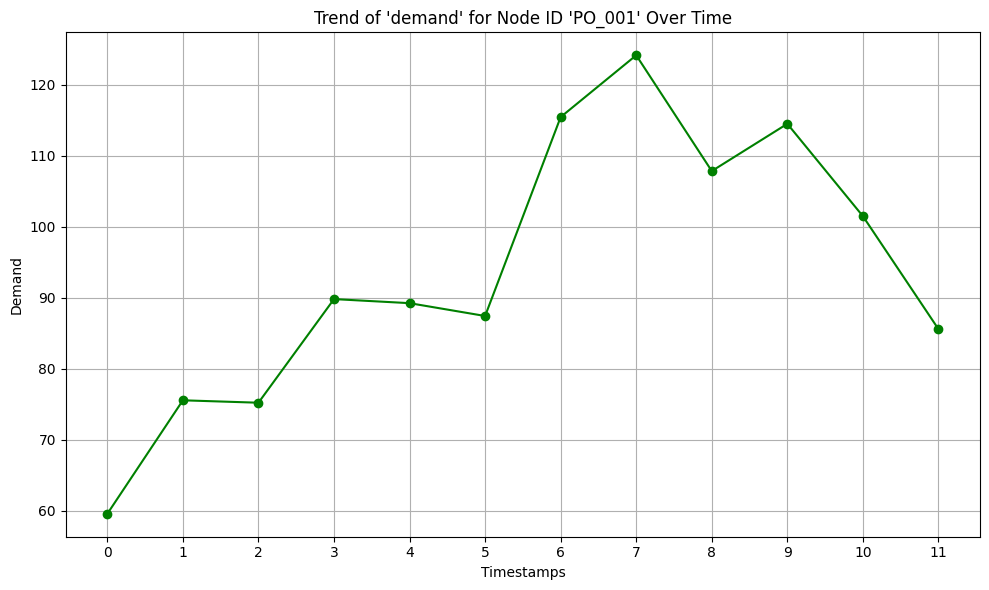

Time taken by 'plot_attribute_for_node': 1.18 seconds
Memory used by 'plot_attribute_for_node': 874.11 KiB (Current), 12038.21 KiB (Peak)


In [18]:
plot_attribute_for_node(temporal_graph, node_id="PO_001", attribute="demand")

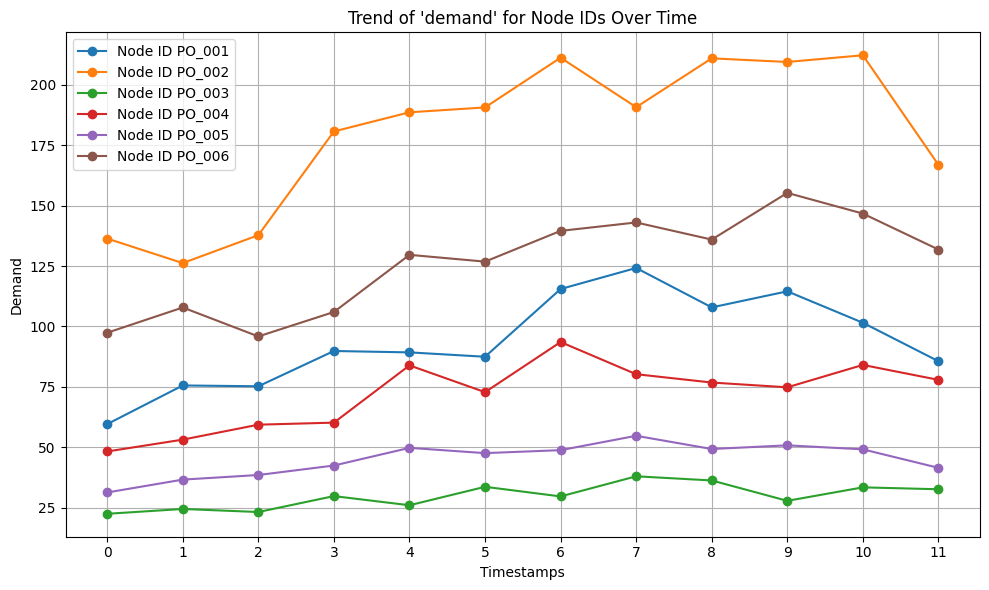

Time taken by 'plot_attribute_for_nodes': 1.42 seconds
Memory used by 'plot_attribute_for_nodes': 1202.83 KiB (Current), 12041.14 KiB (Peak)


In [19]:
# More than one node_id _ separate average

import matplotlib.pyplot as plt
import json

@time_and_memory
def plot_attribute_for_nodes(temporal_graph, node_ids, attribute):
    """
    Plots the value of a specified attribute for given node IDs across all timestamps.
    Raises an error if the attribute is not present in any of the nodes.

    Parameters:
        temporal_graph (TemporalGraph): The temporal graph containing the data.
        node_ids (list): The list of node IDs to track.
        attribute (str): The attribute to track (e.g., "cost").
    """
    # Store timestamp and attribute values for each node
    timestamps = []
    attribute_values = {node_id: [] for node_id in node_ids}
    
    # Flag to check if the attribute is present at least once
    attribute_found = {node_id: False for node_id in node_ids}

    # Iterate over all timestamps in the temporal graph
    for timestamp in range(len(temporal_graph.files)):
        
        # Load the data for the current timestamp
        with open(temporal_graph.files[timestamp], 'r') as f:
            data = json.load(f)
        
        # Check if the node IDs exist in the data
        for node_type, nodes in data["node_values"].items():
            for subnode in nodes:
                for node_id in node_ids:
                    if node_id in subnode:
                        node_index = nodes.index(subnode)
                        node_attributes = data["node_types"][node_type]
                        
                        # Check if the attribute exists for this node type
                        if attribute in node_attributes:
                            attribute_found[node_id] = True
                            value = data["node_values"][node_type][node_index][node_attributes.index(attribute)]
                            if timestamp not in timestamps:
                                timestamps.append(timestamp)  # Use 1-based timestamp indexing
                            attribute_values[node_id].append(value)
                        break  # Exit the loop if the node is found

    for node_id, found in attribute_found.items():
        if not found:
            raise ValueError(f"Attribute '{attribute}' not found for node ID '{node_id}' in any timestamp.")
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    for node_id in node_ids:
        plt.plot(timestamps, attribute_values[node_id], marker='o', linestyle='-', label=f'Node ID {node_id}')
    plt.title(f"Trend of '{attribute}' for Node IDs Over Time")
    plt.xlabel("Timestamps")
    plt.ylabel(attribute.capitalize())
    plt.xticks(timestamps)  # Use integer timestamps as x-ticks
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Example usage
plot_attribute_for_nodes(temporal_graph, node_ids=["PO_001", "PO_002", "PO_003", "PO_004", "PO_005", "PO_006"], attribute="demand")


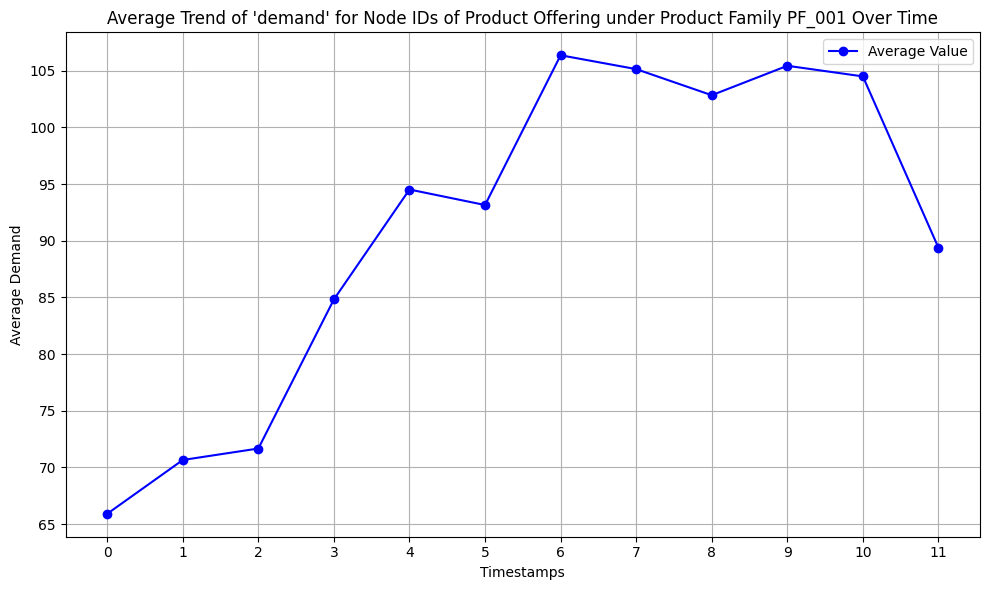

Time taken by 'plot_average_attribute_for_nodes': 1.54 seconds
Memory used by 'plot_average_attribute_for_nodes': 993.99 KiB (Current), 12041.43 KiB (Peak)


In [20]:
# more than one node_id --- of all product offerings under one product family

import matplotlib.pyplot as plt
import json

@time_and_memory
def plot_average_attribute_for_nodes(temporal_graph, node_ids, attribute):
    """
    Plots the average value of a specified attribute for given node IDs across all timestamps.
    Raises an error if the attribute is not present in any of the nodes.

    Parameters:
        temporal_graph (TemporalGraph): The temporal graph containing the data.
        node_ids (list): The list of node IDs to track.
        attribute (str): The attribute to track (e.g., "cost").
    """
    # Store timestamp and attribute values for each node
    timestamps = []
    attribute_values = {node_id: [] for node_id in node_ids}
    
    # Flag to check if the attribute is present at least once
    attribute_found = {node_id: False for node_id in node_ids}

    # Iterate over all timestamps in the temporal graph
    for timestamp in range(len(temporal_graph.files)):
        
        # Load the data for the current timestamp
        with open(temporal_graph.files[timestamp], 'r') as f:
            data = json.load(f)
        
        # Check if the node IDs exist in the data
        for node_type, nodes in data["node_values"].items():
            for subnode in nodes:
                for node_id in node_ids:
                    if node_id in subnode:
                        node_index = nodes.index(subnode)
                        node_attributes = data["node_types"][node_type]
                        
                        # Check if the attribute exists for this node type
                        if attribute in node_attributes:
                            attribute_found[node_id] = True
                            value = data["node_values"][node_type][node_index][node_attributes.index(attribute)]
                            if timestamp not in timestamps:
                                timestamps.append(timestamp)  # Use 1-based timestamp indexing
                            attribute_values[node_id].append(value)
                        break  # Exit the loop if the node is found

    for node_id, found in attribute_found.items():
        if not found:
            raise ValueError(f"Attribute '{attribute}' not found for node ID '{node_id}' in any timestamp.")
    
    # Calculate the average attribute values across all node IDs
    average_values = []
    for i in range(len(timestamps)):
        sum_values = sum(attribute_values[node_id][i] for node_id in node_ids)
        average_values.append(sum_values / len(node_ids))
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, average_values, marker='o', linestyle='-', color='b', label='Average Value')
    plt.title(f"Average Trend of '{attribute}' for Node IDs of Product Offering under Product Family PF_001 Over Time")
    plt.xlabel("Timestamps")
    plt.ylabel(f"Average {attribute.capitalize()}")
    plt.xticks(timestamps)  # Use integer timestamps as x-ticks
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Example usage
plot_average_attribute_for_nodes(temporal_graph, node_ids=["PO_001", "PO_002", "PO_003", "PO_004", "PO_005", "PO_006"], attribute="demand")


# 25/11/2024 - Queries

# Edge Atrribute

In [21]:
import json

@time_and_memory
def edgeattr_json(temporal_graph, timestamp, relationship_type, vars):
    """
    Retrieve edge attributes for given relationship type and variables from the JSON data at a specific timestamp.
    """
    with open(temporal_graph.files[timestamp], 'r') as f:
        data = json.load(f)
    
    # Find the indices of the variables
    if relationship_type in data["relationship_types"]:
        try:
            indices = [data["relationship_types"][relationship_type].index(var) for var in vars]
        except ValueError:
            return None  # If any variable is not found in the relationship type
    
        # Fetch the edge attributes
        edge_attributes = []
        for edge in data["relationship_values"]:
            if edge[0] == relationship_type:
                edge_attr = {var: edge[index] for var, index in zip(vars, indices)}
                edge_attributes.append(edge_attr)
        return edge_attributes
    
    return None  # If relationship type is not found

# Example usage

timestamp = 3
relationship_type = "SupplierToWarehouse"
vars = ["transportation_cost", "lead_time"]
attributes = edgeattr_json(temporal_graph, timestamp, relationship_type, vars)
print(attributes)


Time taken by 'edgeattr_json': 0.09 seconds
Memory used by 'edgeattr_json': 137.11 KiB (Current), 6986.83 KiB (Peak)
[{'transportation_cost': 514.1072274167296, 'lead_time': 24.997804513400826}, {'transportation_cost': 496.22240047560894, 'lead_time': 28.432685446016624}, {'transportation_cost': 615.389094092333, 'lead_time': 26.98818016842331}, {'transportation_cost': 52.41014818107123, 'lead_time': 17.535745609414796}, {'transportation_cost': 819.2493833545408, 'lead_time': 21.540842049775787}, {'transportation_cost': 482.6660484724229, 'lead_time': 29.861918196841835}, {'transportation_cost': 63.51352109962569, 'lead_time': 22.48190081869189}, {'transportation_cost': 600.9506656601562, 'lead_time': 12.017914881232842}, {'transportation_cost': 890.9726321241359, 'lead_time': 9.470537229745762}, {'transportation_cost': 731.1075237319992, 'lead_time': 9.706378877970481}, {'transportation_cost': 683.6723244390198, 'lead_time': 16.60043241381002}, {'transportation_cost': 742.987721534556

# For a given threshold value for operating_cost compare it with the highest operating cost and find the product offering with the highest operating cost

In [22]:
import json

def find_product_offering_with_highest_operating_cost(temporal_graph, threshold_operating_cost):
    """
    Finds the product offering connected as target to the facility with the highest operating cost based on the given threshold.
    Parameters:
        temporal_graph (TemporalGraph): The temporal graph containing the data.
        threshold_operating_cost (float): The threshold value for operating cost.
    Returns:
        The product offering ID connected to the facility with the highest operating cost above the threshold.
    """
    highest_operating_cost = 0
    product_offering_id = None
    
    # Iterate over all timestamps in the temporal graph
    for timestamp in range(len(temporal_graph.files)):
        # Load the data for the current timestamp
        with open(temporal_graph.files[timestamp], 'r') as f:
            data = json.load(f)
        
        # Check edge attributes for FacilityToProductOfferings
        for edge in data["relationship_values"]:
            if edge[0] == "FacilityToProductOfferings":
                source_id = edge[4]
                target_id = edge[5]
                
                # Find the facility with the matching source_id
                facility = next((facility for facility in data["node_values"]["Facility"] if facility[-1] == source_id), None)
                if facility:
                    operating_cost = facility[5]
                    
                    if operating_cost > threshold_operating_cost and operating_cost > highest_operating_cost:
                        highest_operating_cost = operating_cost
                        product_offering_id = target_id
        
        print(f"Highest operating cost at timestamp {timestamp}: {highest_operating_cost}, Product Offering: {product_offering_id}")
    
    return product_offering_id


threshold_operating_cost = 4

product_offering_id = find_product_offering_with_highest_operating_cost(temporal_graph, threshold_operating_cost)
print(f"Product offering connected to the facility with the highest operating cost above {threshold_operating_cost}: {product_offering_id}")


Highest operating cost at timestamp 0: 9811.650693068319, Product Offering: PO_016
Highest operating cost at timestamp 1: 9811.650693068319, Product Offering: PO_016
Highest operating cost at timestamp 2: 9811.650693068319, Product Offering: PO_016
Highest operating cost at timestamp 3: 9811.650693068319, Product Offering: PO_016
Highest operating cost at timestamp 4: 9811.650693068319, Product Offering: PO_016
Highest operating cost at timestamp 5: 9811.650693068319, Product Offering: PO_016
Highest operating cost at timestamp 6: 9811.650693068319, Product Offering: PO_016
Highest operating cost at timestamp 7: 9811.650693068319, Product Offering: PO_016
Highest operating cost at timestamp 8: 9811.650693068319, Product Offering: PO_016
Highest operating cost at timestamp 9: 9811.650693068319, Product Offering: PO_016
Highest operating cost at timestamp 10: 9811.650693068319, Product Offering: PO_016
Highest operating cost at timestamp 11: 9811.650693068319, Product Offering: PO_016
Pr

# for a given threshold of operating_cost find all the product offerings that falls under the threshold value

In [23]:
import json

def find_product_offerings_under_threshold(temporal_graph, threshold_operating_cost):
    """
    Finds all product offerings connected to facilities with operating costs under the given threshold.
    Parameters:
        temporal_graph (TemporalGraph): The temporal graph containing the data.
        threshold_operating_cost (float): The threshold value for operating cost.
    Returns:
        List of product offering IDs connected to facilities with operating costs under the threshold.
    """
    product_offerings_under_threshold = []
    
    # Iterate over all timestamps in the temporal graph
    for timestamp in range(len(temporal_graph.files)):
        # Load the data for the current timestamp
        with open(temporal_graph.files[timestamp], 'r') as f:
            data = json.load(f)
        
        # Check edge attributes for FacilityToProductOfferings
        for edge in data["relationship_values"]:
            if edge[0] == "FacilityToProductOfferings":
                source_id = edge[4]
                target_id = edge[5]
                
                # Find the facility with the matching source_id
                facility = next((facility for facility in data["node_values"]["Facility"] if facility[-1] == source_id), None)
                if facility:
                    operating_cost = facility[5]
                    
                    if operating_cost <= threshold_operating_cost:
                        product_offerings_under_threshold.append(target_id)
        
        print(f"Product offerings under threshold at timestamp {timestamp}: {product_offerings_under_threshold}")
    
    return product_offerings_under_threshold


threshold_operating_cost = 2000.0

product_offerings = find_product_offerings_under_threshold(temporal_graph, threshold_operating_cost)
print(f"Product offerings connected to facilities with operating costs under {threshold_operating_cost}: {product_offerings}")


Product offerings under threshold at timestamp 0: ['PO_003', 'PO_018', 'PO_020', 'PO_002', 'PO_017', 'PO_015', 'PO_006', 'PO_021', 'PO_016', 'PO_001', 'PO_010', 'PO_008', 'PO_002', 'PO_015', 'PO_006', 'PO_004', 'PO_021', 'PO_018', 'PO_007', 'PO_011', 'PO_019', 'PO_018', 'PO_003', 'PO_012', 'PO_015', 'PO_014', 'PO_010', 'PO_019', 'PO_005', 'PO_004', 'PO_010', 'PO_011', 'PO_006', 'PO_018', 'PO_016', 'PO_017', 'PO_019', 'PO_014', 'PO_017', 'PO_013', 'PO_021', 'PO_019', 'PO_009', 'PO_007', 'PO_003', 'PO_010', 'PO_003', 'PO_007', 'PO_012', 'PO_016', 'PO_011', 'PO_021', 'PO_013', 'PO_017', 'PO_005', 'PO_007', 'PO_017', 'PO_006', 'PO_014', 'PO_009', 'PO_002', 'PO_014', 'PO_008', 'PO_007', 'PO_009', 'PO_005', 'PO_017', 'PO_006']
Product offerings under threshold at timestamp 1: ['PO_003', 'PO_018', 'PO_020', 'PO_002', 'PO_017', 'PO_015', 'PO_006', 'PO_021', 'PO_016', 'PO_001', 'PO_010', 'PO_008', 'PO_002', 'PO_015', 'PO_006', 'PO_004', 'PO_021', 'PO_018', 'PO_007', 'PO_011', 'PO_019', 'PO_018'

# Highest Leadtime taken for product offering with the highest demand

In [24]:
import json

def find_product_offering_with_highest_lead_time_and_demand(temporal_graph, threshold_lead_time):
    """
    Finds the product offering connected as target to the facility with the highest lead time based on the given threshold,
    and checks if the product offering has high demand. Displays the highest demand.
    Parameters:
        temporal_graph (TemporalGraph): The temporal graph containing the data.
        threshold_lead_time (float): The threshold value for lead time.
    Returns:
        The product offering ID connected to the facility with the highest lead time above the threshold and its highest demand.
    """
    highest_lead_time = 0
    highest_demand = 0
    product_offering_id = None
    
    # Iterate over all timestamps in the temporal graph
    for timestamp in range(len(temporal_graph.files)):
        # Load the data for the current timestamp
        with open(temporal_graph.files[timestamp], 'r') as f:
            data = json.load(f)
        
        # Check edge attributes for FacilityToProductOfferings
        for edge in data["relationship_values"]:
            if edge[0] == "FacilityToProductOfferings":
                lead_time = edge[2]
                target_id = edge[5]
                
                if lead_time > threshold_lead_time and lead_time > highest_lead_time:
                    # Find the product offering with the matching target_id
                    product_offering = next((po for po in data["node_values"]["ProductOffering"] if po[-1] == target_id), None)
                    if product_offering:
                        demand_index = data["node_types"]["ProductOffering"].index("demand")
                        demand = product_offering[demand_index]
                        
                        if demand > highest_demand:
                            highest_lead_time = lead_time
                            highest_demand = demand
                            product_offering_id = target_id
        
        print(f"Highest lead time at timestamp {timestamp}: {highest_lead_time}, Product Offering: {product_offering_id}, Highest Demand: {highest_demand}")
    
    return product_offering_id, highest_demand


threshold_lead_time = 10.0

product_offering_id, highest_demand = find_product_offering_with_highest_lead_time_and_demand(temporal_graph, threshold_lead_time)
print(f"Product offering connected to the facility with the highest lead time above {threshold_lead_time}: {product_offering_id}, Highest Demand: {highest_demand}")


Highest lead time at timestamp 0: 29.267236865310725, Product Offering: PO_002, Highest Demand: 136.34781009455867
Highest lead time at timestamp 1: 29.267236865310725, Product Offering: PO_002, Highest Demand: 136.34781009455867
Highest lead time at timestamp 2: 29.267236865310725, Product Offering: PO_002, Highest Demand: 136.34781009455867
Highest lead time at timestamp 3: 29.267236865310725, Product Offering: PO_002, Highest Demand: 136.34781009455867
Highest lead time at timestamp 4: 29.636688141095046, Product Offering: PO_008, Highest Demand: 178.05658176272036
Highest lead time at timestamp 5: 29.636688141095046, Product Offering: PO_008, Highest Demand: 178.05658176272036
Highest lead time at timestamp 6: 29.636688141095046, Product Offering: PO_008, Highest Demand: 178.05658176272036
Highest lead time at timestamp 7: 29.636688141095046, Product Offering: PO_008, Highest Demand: 178.05658176272036
Highest lead time at timestamp 8: 29.636688141095046, Product Offering: PO_008, 

# Query to find the parts with highest cost and importance factor with expiry days based on the type of the part and a cost threshold

In [ ]:
import json
import glob
import re
from datetime import datetime

def find_parts_with_highest_cost_and_importance(temporal_graph, threshold_cost, p_type):
    highest_cost = 0
    highest_importance_factor = 0
    part_with_highest_cost_and_importance = None
    
    # Iterate over all timestamps in the temporal graph
    for timestamp in range(len(temporal_graph.files)):
        # Load the data for the current timestamp
        with open(temporal_graph.files[timestamp], 'r') as f:
            data = json.load(f)
        
        # Check node attributes for Parts
        for part in data["node_values"]["Parts"]:
            part_type = part[2]
            if part_type == p_type: # either all the part types or either or option here
            #print(f"Part type: {part_type}")
                cost = part[4]
                importance_factor = part[5]
            
            if cost > threshold_cost and cost > highest_cost and importance_factor > highest_importance_factor:
                highest_cost = cost
                highest_importance_factor = importance_factor
                part_with_highest_cost_and_importance = part
                print(f"Part with highest cost and importance factor (higher than threshold value) at timestamp {timestamp}: {part_with_highest_cost_and_importance}, input: {threshold_cost}")
                print(f"Days to expiry: {days_to_expiry}")


            #cost is above the threshold & matches highest cost & imp factor is high
            elif cost > threshold_cost and cost == highest_cost and importance_factor > highest_importance_factor: 
                highest_importance_factor = importance_factor
                part_with_highest_cost_and_importance = part
                print(f"Part with highest cost and importance factor (cost equals highest cost) at timestamp {timestamp}: {part_with_highest_cost_and_importance}, input: {threshold_cost}")
                print(f"Days to expiry: {days_to_expiry}")
                
            #cost equals threshold cost but higher than the highest cost & imp factor is high 
            elif cost == threshold_cost and cost > highest_cost and importance_factor > highest_importance_factor:
                highest_cost = cost
                highest_importance_factor = importance_factor
                part_with_highest_cost_and_importance = part  
                print(f"Part with highest cost and importance factor (cost equals threshold cost) at timestamp {timestamp}: {part_with_highest_cost_and_importance}, input: {threshold_cost}")
                print(f"Days to expiry: {days_to_expiry}")  
                break
            
    
    # if part_with_highest_cost_and_importance:
    #     valid_from = datetime.strptime(part_with_highest_cost_and_importance[6], "%Y-%m-%d")
    #     valid_till = datetime.strptime(part_with_highest_cost_and_importance[7], "%Y-%m-%d")
    #     days_to_expiry = (valid_till - valid_from).days
        
        # print(f"Part with highest cost and importance factor: {part_with_highest_cost_and_importance}")
        # print(f"Days to expiry: {days_to_expiry}")
    
    return part_with_highest_cost_and_importance, days_to_expiry


# Example usage
threshold_cost = 10.0
#p_type = 'subassembly'
p_type='raw'

try:
    part_with_highest_cost_and_importance, days_to_expiry = find_parts_with_highest_cost_and_importance(temporal_graph, threshold_cost, p_type)
    # print(f"Part with highest cost and importance factor: {part_with_highest_cost_and_importance}")
    # print(f"Days to expiry: {days_to_expiry}")
except FileNotFoundError as e:
    print(f"Error: {e}")
except IndexError as e:
    print(f"Error: {e}")


Part with highest cost and importance factor (higher than threshold value) at timestamp 0: ['Parts', 'Part_1', 'raw', 'plastic_component', 6746.60052469849, 0.786505360571591, '2024-01-01', '2025-10-22', 'P_001'], input: 10.0
Days to expiry: 390
Part with highest cost and importance factor (higher than threshold value) at timestamp 0: ['Parts', 'Part_26', 'raw', 'electronic_component', 7990.061848646855, 0.8289693776689301, '2024-01-01', '2025-10-22', 'P_026'], input: 10.0
Days to expiry: 390
Part with highest cost and importance factor (higher than threshold value) at timestamp 0: ['Parts', 'Part_39', 'raw', 'chemical', 8583.732075718903, 0.9590832884291722, '2024-01-01', '2025-12-21', 'P_039'], input: 10.0
Days to expiry: 390
Part with highest cost and importance factor (higher than threshold value) at timestamp 3: ['Parts', 'Part_108', 'raw', 'metal_rod', 9067.18030448008, 0.9740063829149778, '2024-01-01', '2025-06-24', 'P_108'], input: 10.0
Days to expiry: 390
Part with highest cos

# Optimization of Degree Centrality - using direct json query with relationshiph_types & link_values

In [ ]:
#OLD one


def count_connections_and_find_max_nodes(): #temporal_graph, timestamp
    connection_counts = {}

# Load the data from the JSON file
    with open(file_path, 'r') as f:
        data = json.load(f)

        # Iterate over all edges in the relationship values
        for edge in data["link_values"]:
            # Determine the relationship type
            relationship_type = edge[0]
            relationship_structure = data["relationship_types"].get(relationship_type, [])

            # Find the indices for source and target based on the relationship structure
            try:
                source_index = relationship_structure.index("source")
                target_index = relationship_structure.index("target")
            except ValueError:
                continue  # Skip if source or target is not found in the structure

            # Extract source and target nodes
            source = edge[source_index] if len(edge) > source_index else None
            target = edge[target_index] if len(edge) > target_index else None

            # Update connection counts
            if source is not None:
                if source not in connection_counts:
                    connection_counts[source] = {"outgoing": 0, "incoming": 0}
                connection_counts[source]["outgoing"] += 1

            if target is not None:
                if target not in connection_counts:
                    connection_counts[target] = {"outgoing": 0, "incoming": 0}
                connection_counts[target]["incoming"] += 1

    # Calculate degree centrality and find nodes with maximum connections
    max_connections = 0
    nodes_with_max_connections = []
    
    degree_centrality = {}
    for node, counts in connection_counts.items():
        total_connections = counts["outgoing"] + counts["incoming"]
        degree_centrality[node] = total_connections
        if total_connections > max_connections:
            max_connections = total_connections
            nodes_with_max_connections = [node]
        elif total_connections == max_connections:
            nodes_with_max_connections.append(node)

    return nodes_with_max_connections, max_connections, connection_counts, degree_centrality

# Example usage
try:
    #timestamp = 0
    file_path = '/home/rm_subhiksha/LAM_SRM/Query_jsongraph/Dataset_Surya/NSS_1000_36_Compressed/NSS_1000_36/timestamp_1.json'
    nodes_with_max_connections, max_connections, connection_counts, degree_centrality = count_connections_and_find_max_nodes()#temporal_graph, timestamp
    print(f"Nodes with maximum connections: {nodes_with_max_connections}, Max Connections: {max_connections}")
    print(f"Connection Counts: {connection_counts}")
    print(f"Degree Centrality: {degree_centrality}")
except FileNotFoundError as e:
    print(f"Error: {e}")
except IndexError as e:
    print(f"Error: {e}")


Nodes with maximum connections: ['F_003', 'F_036', 'F_080'], Max Connections: 151
Connection Counts: {'BG_001': {'outgoing': 4, 'incoming': 0}, 'PF_001': {'outgoing': 6, 'incoming': 1}, 'PF_002': {'outgoing': 3, 'incoming': 1}, 'PF_003': {'outgoing': 7, 'incoming': 1}, 'PF_004': {'outgoing': 5, 'incoming': 1}, 'PO_001': {'outgoing': 50, 'incoming': 11}, 'PO_002': {'outgoing': 50, 'incoming': 14}, 'PO_003': {'outgoing': 50, 'incoming': 17}, 'PO_004': {'outgoing': 50, 'incoming': 15}, 'PO_005': {'outgoing': 50, 'incoming': 14}, 'PO_006': {'outgoing': 50, 'incoming': 23}, 'PO_007': {'outgoing': 50, 'incoming': 21}, 'PO_008': {'outgoing': 50, 'incoming': 15}, 'PO_009': {'outgoing': 50, 'incoming': 19}, 'PO_010': {'outgoing': 50, 'incoming': 19}, 'PO_011': {'outgoing': 50, 'incoming': 14}, 'PO_012': {'outgoing': 50, 'incoming': 19}, 'PO_013': {'outgoing': 50, 'incoming': 16}, 'PO_014': {'outgoing': 50, 'incoming': 17}, 'PO_015': {'outgoing': 50, 'incoming': 20}, 'PO_016': {'outgoing': 50, '

# New one - /home/rm_subhiksha/LAM_SRM/Query_jsongraph/NSS_1000_12_timestamp_1.json

In [1]:
import json
from collections import defaultdict

def count_connections_and_find_max_nodes(file_path): #temporal_graph, timestamp
    connection_counts = {}
    neighbors = defaultdict(lambda: {
        "immediate_predecessors": set(), "secondary_predecessors": set(), "tertiary_predecessors": set(),
        "immediate_successors": set(), "secondary_successors": set(), "tertiary_successors": set()
    })

    # Load the data from the JSON file
    with open(file_path, 'r') as f:
        data = json.load(f)

        # Iterate over all edges in the relationship values
        for relationship_type, edges in data["link_values"].items():
            relationship_structure = data["relationship_types"].get(relationship_type, [])

            for edge in edges:
                # Find the indices for source and target based on the relationship structure
                try:
                    source_index = relationship_structure.index("source")
                    target_index = relationship_structure.index("target")
                except ValueError:
                    continue  # Skip if source or target is not found in the structure

                # Extract source and target nodes
                source = edge[source_index] if len(edge) > source_index else None
                target = edge[target_index] if len(edge) > target_index else None

                # Update connection counts
                if source is not None:
                    if source not in connection_counts:
                        connection_counts[source] = {"outgoing": 0, "incoming": 0}
                    connection_counts[source]["outgoing"] += 1

                if target is not None:
                    if target not in connection_counts:
                        connection_counts[target] = {"outgoing": 0, "incoming": 0}
                    connection_counts[target]["incoming"] += 1

                # Update neighbors
                if source and target:
                    neighbors[source]["immediate_successors"].add(target)
                    neighbors[target]["immediate_predecessors"].add(source)

    # Calculate secondary and tertiary level neighbors
    for node in neighbors:
        for immediate_successor in neighbors[node]["immediate_successors"]:
            neighbors[node]["secondary_successors"].update(neighbors[immediate_successor]["immediate_successors"])
        neighbors[node]["secondary_successors"].discard(node)  # Remove self if present

        for secondary_successor in neighbors[node]["secondary_successors"]:
            neighbors[node]["tertiary_successors"].update(neighbors[secondary_successor]["immediate_successors"])
        neighbors[node]["tertiary_successors"].discard(node)  # Remove self if present
        neighbors[node]["tertiary_successors"].difference_update(neighbors[node]["immediate_successors"])  # Remove immediate successors

        for immediate_predecessor in neighbors[node]["immediate_predecessors"]:
            neighbors[node]["secondary_predecessors"].update(neighbors[immediate_predecessor]["immediate_predecessors"])
        neighbors[node]["secondary_predecessors"].discard(node)  # Remove self if present

        for secondary_predecessor in neighbors[node]["secondary_predecessors"]:
            neighbors[node]["tertiary_predecessors"].update(neighbors[secondary_predecessor]["immediate_predecessors"])
        neighbors[node]["tertiary_predecessors"].discard(node)  # Remove self if present
        neighbors[node]["tertiary_predecessors"].difference_update(neighbors[node]["immediate_predecessors"])  # Remove immediate predecessors

    # Calculate degree centrality and find nodes with maximum connections
    max_connections = 0
    nodes_with_max_connections = []
    
    degree_centrality = {}
    for node, counts in connection_counts.items():
        total_connections = counts["outgoing"] + counts["incoming"]
        degree_centrality[node] = total_connections
        if total_connections > max_connections:
            max_connections = total_connections
            nodes_with_max_connections = [node]
        elif total_connections == max_connections:
            nodes_with_max_connections.append(node)

    return nodes_with_max_connections, max_connections, connection_counts, degree_centrality, neighbors

# Example usage
try:
    file_path = '/home/rm_subhiksha/LAM_SRM/Query_jsongraph/NSS_1000_12_timestamp_1.json'
    nodes_with_max_connections, max_connections, connection_counts, degree_centrality, neighbors = count_connections_and_find_max_nodes(file_path)
    print(f"Nodes with maximum connections: {nodes_with_max_connections}, Max Connections: {max_connections}")
    print(f"Connection Counts: {connection_counts}")
    print(f"Degree Centrality: {degree_centrality}")
    for node, neighbor_types in neighbors.items():
        print(f"Node: {node}")
        print(f"  Immediate Predecessors: {list(neighbor_types['immediate_predecessors'])}")
        print(f"  Secondary Predecessors: {list(neighbor_types['secondary_predecessors'])}")
        print(f"  Tertiary Predecessors: {list(neighbor_types['tertiary_predecessors'])}")
        print(f"  Immediate Successors: {list(neighbor_types['immediate_successors'])}")
        print(f"  Secondary Successors: {list(neighbor_types['secondary_successors'])}")
        print(f"  Tertiary Successors: {list(neighbor_types['tertiary_successors'])}")
except FileNotFoundError as e:
    print(f"Error: {e}")
except IndexError as e:
    print(f"Error: {e}")


Nodes with maximum connections: ['P_416', 'P_415'], Max Connections: 27
Connection Counts: {'BG_001': {'outgoing': 4, 'incoming': 0}, 'PF_001': {'outgoing': 6, 'incoming': 1}, 'PF_002': {'outgoing': 3, 'incoming': 1}, 'PF_003': {'outgoing': 7, 'incoming': 1}, 'PF_004': {'outgoing': 5, 'incoming': 1}, 'PO_001': {'outgoing': 0, 'incoming': 7}, 'PO_002': {'outgoing': 0, 'incoming': 8}, 'PO_003': {'outgoing': 0, 'incoming': 9}, 'PO_004': {'outgoing': 0, 'incoming': 9}, 'PO_005': {'outgoing': 0, 'incoming': 11}, 'PO_006': {'outgoing': 0, 'incoming': 7}, 'PO_007': {'outgoing': 0, 'incoming': 9}, 'PO_008': {'outgoing': 0, 'incoming': 9}, 'PO_009': {'outgoing': 0, 'incoming': 14}, 'PO_010': {'outgoing': 0, 'incoming': 8}, 'PO_011': {'outgoing': 0, 'incoming': 7}, 'PO_012': {'outgoing': 0, 'incoming': 11}, 'PO_013': {'outgoing': 0, 'incoming': 8}, 'PO_014': {'outgoing': 0, 'incoming': 11}, 'PO_015': {'outgoing': 0, 'incoming': 4}, 'PO_016': {'outgoing': 0, 'incoming': 9}, 'PO_017': {'outgoing':

# Degree Centrality Sorted based on Groupings, Nodes with Max_Connections ---- Try Normalizing the values to the possible degree to get networkx like results

In [6]:
import json

def count_connections_and_find_max_nodes(file_path):
    connection_counts = {}

    # Load the data from the JSON file
    with open(file_path, 'r') as f:
        data = json.load(f)

        # Iterate over all edges in the relationship values
        for edge in data["link_values"]:
            # Determine the relationship type
            relationship_type = edge[0]
            relationship_structure = data["relationship_types"].get(relationship_type, [])

            # Find the indices for source and target based on the relationship structure
            try:
                source_index = relationship_structure.index("source")
                target_index = relationship_structure.index("target")
            except ValueError:
                continue  # Skip if source or target is not found in the structure

            # Extract source and target nodes
            source = edge[source_index] if len(edge) > source_index else None
            target = edge[target_index] if len(edge) > target_index else None

            # Update connection counts
            if source is not None:
                if source not in connection_counts:
                    connection_counts[source] = {"outgoing": 0, "incoming": 0}
                connection_counts[source]["outgoing"] += 1

            if target is not None:
                if target not in connection_counts:
                    connection_counts[target] = {"outgoing": 0, "incoming": 0}
                connection_counts[target]["incoming"] += 1

    # Calculate degree centrality
    degree_centrality = {node: counts["outgoing"] + counts["incoming"] for node, counts in connection_counts.items()}

    # Group nodes by type
    grouped_nodes = {
        "BusinessGroup": [],
        "ProductFamily": [],
        "ProductOffering": [],
        "Facility": [],
        "Parts": [],
        "Suppliers": [],
        "Warehouse": []
    }

    max_connections_nodes = []
    max_connections = 0

    for node, centrality in degree_centrality.items():
        if node.startswith("BG_"):
            grouped_nodes["BusinessGroup"].append((node, centrality))
        elif node.startswith("PF_"):
            grouped_nodes["ProductFamily"].append((node, centrality))
        elif node.startswith("PO_"):
            grouped_nodes["ProductOffering"].append((node, centrality))
        elif node.startswith("F_"):
            grouped_nodes["Facility"].append((node, centrality))
        elif node.startswith("P_"):
            grouped_nodes["Parts"].append((node, centrality))
        elif node.startswith("S_"):
            grouped_nodes["Suppliers"].append((node, centrality))
        elif node.startswith("W_"):
            grouped_nodes["Warehouse"].append((node, centrality))

        # Find nodes with maximum connections
        if centrality > max_connections:
            max_connections = centrality
            max_connections_nodes = [node]
        elif centrality == max_connections:
            max_connections_nodes.append(node)

    # Sort each group by degree centrality in descending order
    for group in grouped_nodes:
        grouped_nodes[group].sort(key=lambda x: x[1], reverse=True)

    return grouped_nodes, max_connections_nodes, max_connections

# Example usage
file_path ='/home/rm_subhiksha/LAM_SRM/Query_jsongraph/Dataset_Surya/NSS_1000_36_Compressed/NSS_1000_36/timestamp_1.json'
grouped_nodes, max_connections_nodes, max_connections = count_connections_and_find_max_nodes(file_path)

for group, nodes in grouped_nodes.items():
    print(f"{group}: {nodes}")

print(f"Nodes with maximum connections: {max_connections_nodes}")
print(f"Count of maximum connections: {max_connections}")


BusinessGroup: [('BG_001', 4)]
ProductFamily: [('PF_003', 8), ('PF_001', 7), ('PF_004', 6), ('PF_002', 4)]
ProductOffering: [('PO_006', 73), ('PO_016', 72), ('PO_007', 71), ('PO_015', 70), ('PO_021', 70), ('PO_009', 69), ('PO_010', 69), ('PO_012', 69), ('PO_018', 69), ('PO_017', 68), ('PO_003', 67), ('PO_014', 67), ('PO_020', 67), ('PO_013', 66), ('PO_004', 65), ('PO_008', 65), ('PO_002', 64), ('PO_005', 64), ('PO_011', 64), ('PO_001', 61), ('PO_019', 61)]
Facility: [('F_003', 151), ('F_036', 151), ('F_080', 151), ('F_016', 147), ('F_069', 146), ('F_031', 145), ('F_055', 144), ('F_015', 142), ('F_013', 140), ('F_086', 140), ('F_007', 139), ('F_079', 139), ('F_009', 138), ('F_005', 136), ('F_056', 135), ('F_049', 128), ('F_071', 127), ('F_078', 125), ('F_083', 124), ('F_017', 123), ('F_018', 123), ('F_025', 122), ('F_001', 120), ('F_021', 120), ('F_046', 118), ('F_063', 118), ('F_072', 114), ('F_085', 110), ('F_090', 110), ('F_107', 109), ('F_006', 108), ('F_099', 108), ('F_030', 107), 

In [ ]:
#shortest path 
import json
import heapq

def parse_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def build_graph(data, parts_type):
    graph = {}
    parts_nodes = {part[-1]: part for part in data["node_values"]["PARTS"] if part[2] == parts_type}
    
    for relationship_type, edges in data["link_values"].items():
        for edge in edges:
            source = edge[-2]
            target = edge[-1]
            
            # Check if the edge is PartsToFacility and if the part type matches
            if relationship_type == "PARTSToFACILITY" and target not in parts_nodes:
                continue
            
            attributes = {key: edge[idx] for idx, key in enumerate(data["relationship_types"][relationship_type]) if key not in ["relationship_type", "source", "target"]}
            if source not in graph:
                graph[source] = {}
            if target not in graph:
                graph[target] = {}
            graph[source][target] = attributes
    return graph

def normalize(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value) if max_value != min_value else 0

def dijkstra(graph, start, target, weight_keys):
    pq = [(0, start)]
    distances = {start: 0}
    parents = {start: None}

    while pq:
        current_weight, current_node = heapq.heappop(pq)
        print(f"Processing node: {current_node} with current weight: {current_weight}")

        if current_node == target:
            break

        for neighbor, attributes in graph[current_node].items():
            try:
                combined_weight = sum(normalize(attributes[key], 0, 1) for key in weight_keys if key in attributes)
            except KeyError as e:
                print(f"KeyError: {e} not found in attributes of edge from {current_node} to {neighbor}")
                continue
            new_weight = current_weight + combined_weight

            if neighbor not in distances or new_weight < distances[neighbor]:
                distances[neighbor] = new_weight
                parents[neighbor] = current_node
                heapq.heappush(pq, (new_weight, neighbor))
                print(f"Updated distance for node: {neighbor} to {new_weight}")

    # Reconstruct the path
    path = []
    node = target
    while node is not None:
        path.append(node)
        if node not in parents:
            raise KeyError(f"Node {node} not found in parents dictionary. Path reconstruction failed.")
        node = parents[node]
    path.reverse()

    return path, distances[target]

# Example usage
file_path = '/home/rm_subhiksha/LAM_SRM/Query_jsongraph/NSS_1000_12_timestamp_1.json'
data = parse_json(file_path)
parts_type = 'chemical'
graph = build_graph(data, parts_type)

# Print the built graph
print("Graph:")
for source, targets in graph.items():
    for target, attributes in targets.items():
        print(f"{source} -> {target}: {attributes}")

# Define weight keys for each segment
weight_keys_supplier_to_warehouse = ['transportation_cost', 'lead_time']
weight_keys_warehouse_to_parts = ['inventory_level', 'storage_cost']
weight_keys_parts_to_facility = ['distance', 'transport_cost', 'lead_time']

# Combine all weight keys
all_weight_keys = weight_keys_supplier_to_warehouse + weight_keys_warehouse_to_parts + weight_keys_parts_to_facility

# Find the shortest path from supplier to facility
source_supplier_id = 'S_001'
target_facility_id = 'F_248'
path, total_weight = dijkstra(graph, source_supplier_id, target_facility_id, all_weight_keys)

print(f"Shortest path from {source_supplier_id} to {target_facility_id}: {path}")
print(f"Total normalized weight: {total_weight}")


Graph:
BG_001 -> PF_001: {}
BG_001 -> PF_002: {}
BG_001 -> PF_003: {}
BG_001 -> PF_004: {}
PF_001 -> PO_001: {}
PF_001 -> PO_002: {}
PF_001 -> PO_003: {}
PF_001 -> PO_004: {}
PF_001 -> PO_005: {}
PF_001 -> PO_006: {}
PF_002 -> PO_007: {}
PF_002 -> PO_008: {}
PF_002 -> PO_009: {}
PF_003 -> PO_010: {}
PF_003 -> PO_011: {}
PF_003 -> PO_012: {}
PF_003 -> PO_013: {}
PF_003 -> PO_014: {}
PF_003 -> PO_015: {}
PF_003 -> PO_016: {}
PF_004 -> PO_017: {}
PF_004 -> PO_018: {}
PF_004 -> PO_019: {}
PF_004 -> PO_020: {}
PF_004 -> PO_021: {}
S_001 -> W_063: {'transportation_cost': 548.1926853105945, 'lead_time': 12.539141740145663}
S_001 -> W_079: {'transportation_cost': 599.5527571375724, 'lead_time': 11.371336631856853}
W_063 -> P_414: {'inventory_level': 897, 'storage_cost': 1908.406725190321}
W_063 -> P_387: {'inventory_level': 814, 'storage_cost': 5027.131483826426}
W_063 -> P_446: {'inventory_level': 431, 'storage_cost': 3096.594819449673}
W_063 -> P_427: {'inventory_level': 717, 'storage_cost':

KeyError: 'Node F_248 not found in parents dictionary. Path reconstruction failed.'

### Final Metrics

In [ ]:
print("Time taken:")
print(time_list)
print("curr_mem taken:")
print(curr_mem)
print("peak_mem taken:")
print(peak_mem)